# Week 2 Lab: So where do all those reference genomes come from anyway? (Sequence assembly)

## Part 1
**Due: Monday 4/15/19 11:59PM**

**Partner: ** (optional. You must both turn in the assignment. You must choose a different partner each week. You may also consult with other classmates! And feel free to use the internet to help you)

<br><font color="red">**REMINDER**: We will have our first quiz at the start of the lab section on Thursday (10am). The quiz will cover what we have learned in the first three lectures and the first lab session. Tomorrow's prelab exercise will focus on review questions for the quiz.</font>

Skills covered: genome size estiamtion, sequence assembly, command line one-liners, managing computational resources

### Intro

Today, you will explore using kmer count histograms to estimate the size of a sequenced *E. coli* strain and compare your result to existing software packages for performing this task. On Thursday, you will assemble the sequencing reads into a (semi) complete genome and evaluate the quality of the resulting sequence.

Today’s sequencing reads are in two libraries:

* The first library (“shortfrag”) is paired-end with the read directions toward each other (“innie”). The insert size of the first library is average 215.4 bp (+/- 10.6bp) and the reads are paired end 100bp. We will use this library today to assemble contigs. 

* The second library (“jumping”), is a Nextera mate pair library, with reads oriented away from each other (“outie”). The jumping library read length is 146bp (before trimming adapters, see below) with insert sizes up to several kilobases. This library will be helpful in scaffolding contigs.

Fastq files for the two libraries can be found in the `week2` directory. Do an `ls` to make sure you see the two fastq files for each library:
```shell
ls /datasets/cs185s-sp19-public/week2
```

You should see `shortfrag_1.fq`, `shortfrag_2.fq`, `jumping_1.fq`, and `jumping_2.fq`.

## 1. Inspecting reads with fasqtc

First, open up a terminal and create a `week2` directory in your home directory. `cd` into and work out of there for today.

**Question 1 (2 pts)**: Recall from lab 1 how we used the `fastqc` tool to examine the quality of our reads as a preprocesing step. Apply `fastqc` to the four fastq files. Paste the exact command you used below to do so.

fastqc -o . ../../../datasets/cs185s-sp19-public/week2/shortfrag_1.fq ../../../datasets/cs185s-sp19-public/week2/shortfrag_2.fq ../../../datasets/cs185s-sp19-public/week2/jumping_1.fq ../../../datasets/cs185s-sp19-public/week2/jumping_2.fq

**Question 2 (2 pts)**: Do you see any concerning things (red X's) in the fastqc output? Describe which sections failed for each library and explain how these issues might have occurred.

For the shortfrag fastq files there are red X's for the section per base sequence quality. This might have occured do the sequencing method. In the file it indicates that it is Sanger sequencing which is not as robust for long sequences. We can see that the bases towards the end have really poor quality. For the jumping sequences we get a red X for the adapter content section. This may be cause by the existance of the adapters at the ends of our reads.

## 2. Trimming reads for quality control

Before we move forward with genome size estimation, let's try to address the quality control issues flagged by `fastqc`. We'll be using two tools to help with this:

* `sickle` is a tool for trimming low quality ends of reads. It uses a sliding window trimming algorithm, where a small window slides along the sequence, starting from one end, cutting off sequence until the average quality is above a user specified threshold, then the window keeps going until the average quality drops below that threshold, and cuts off any sequence past that point.

* `nxtrim` is a tool for trimming the special adapter sequences added by Nextera.

First, to learn about `sickle`, type `sickle pe` at the command line.

You can specify both the quality threshold and a length threshold, which will discard any sequences that are shorter than a certain length after trimming. The defaults for both of these values are 20. Run sickle on your data with the default settings, remembering to specify the full paths to the fastq files in the public folder. Below is an example command.

```shell
sickle pe \
    -f file_1.fq \
    -r file_2.fq \
    -t sanger \
    -o trimpair1.fastq \
    -p trimpair2.fastq \
    -s singletons.fastq
```

Note this command should all be on one line. To make it more readable it is broken up into multiple lines. A `\` means the command is continued on the next line. Note the paths given above are not real and are just meant as examples. The general format is the command (sickle pe) followed by flags that tell sickle what the file that comes after the flag is.

You’ll notice that there are 3 output files (`-o`, `-p`, and `-s`). The first two are the trimmed forward and reverse reads, where BOTH the forward and its matching reverse read passed the trimming filter. The singletons file contains reads where one read passed the trimming filter, but its partner did not. The reads that do not pass are not output.

**Question 3 (2 pts):** Run `sickle pe` to trim the `shortfrag` library using default parameters. Be sure to write the output files (`-o`, `-p`, and `-s` files) to your `~/week2` directory. Paste the command you used below.

sickle pe -f ../../../datasets/cs185s-sp19-public/week2/shortfrag_1.fq -r ../../../datasets/cs185s-sp19-public/week2/shortfrag_2.fq -t sanger -o shortfrag_pair1.fastq -p shortfrag_pair2.fastq -s shortfrag_singletons.fastq

Now, we'll deal with trimming the Nextera adapters. The tool `nxtrim` is built for this purpose. To see how to use the tool, type `nxtrim` at the command line. The basic format of the command is:

```shell
nxtrim --separate -1 file_1.fq -2 file_2.fq -O output_prefix
```

You'll have to specify the full path to the Nextera fastq files. Output prefix specifies where to write the output files and how to name them. For instance, if you specify `-O /home/mgymrek/test` it would write things to the directory `/home/mgymrek` and name the files `test.*`. The option `--separate` tells the tool to write two fastq files with each of the read pairs (which we're used to) rather than the default "interleaved" format which writes both read pairs to the same file.

This will produce four output fastq files with a couple differences to files we've seen so far. The four files are:
* `output_prefix_R*.mp.fastq.gz`: read pairs with large insert sizes (what we would expect from a mate pair library). Note `nxtrim` by default reverses the orientation, so after trimming these reads will be "innie" (FR) rather than "outie" (FR).
* `output_prefix.se.fastq.gz`: reads with no pair
* `output_prefix_R*.pe.fastq.gz`: read pairs with short insert sizes (due to experimental artifacts).
* `output_prefix_R*.unknown.fastq.gz`: reads with unknown properties.

Where `R*` is equal to `R1` for the first read in each pair and `R2` for the second read in each pair. For our assembly we'll mostly ignore all but the `*.mp.fastq.gz` files.

Note these fastq files have been zipped using `gzip`.  You can take a look at the output by using `zcat`, which allows you to look at zipped files. For example (you'll have to put the actual path to your `fastq.gz` file):

```shell
zcat output_prefix.pe.fastq.gz | more
```

**Question 4 (2 pts):** Run `nxtrim` to trim Illumina Nextera adapters from the `jumping` library. Be sure to write the output files to your personal `week2` directory. Paste the command you used below.

nxtrim --separate -1 ../../../datasets/cs185s-sp19-public/week2/jumping_1.fq -2 ../../../datasets/cs185s-sp19-public/week2/jumping_2.fq -O jumping_nxtrim

**Question 5 (2 pts):** Rerun `fastqc` on the trimmed libraries. Paste the command you used below. Are there any issues remaining?

fastqc -o . shortfrag_pair1.fastq shortfrag_pair2.fastq

fastqc -o . jumping_nxtrim_R1.mp.fastq.gz jumping_nxtrim_R2.mp.fastq.gz

There are no more red flags but now there are warnings about some of the sequence lengths. The fastqc reports that the sequences range from 20-100 or 20-150. This is just due to some having their adapters/more than their adapters trimmed. 

## 3. Generating and visualizing the kmer distribution

For assembly, we'll just be using the two paired ends of the `shortfrag` library and keep only the `*.mp.fastq.gz` mate pair library from the jumping library. For genome size estimation we will focus on the `shortfrag` library which should be sufficient.

We'll first count k-mers in our data to generate kmer count distributions similar to in the prelab. For this purpose it's ok to only analyze the forward fragment (your trimmed version of `shortfrag_1.fq`).

**Jellyfish** is a kmer counting program that will count the frequency of all possible k-mers of a given length in our data.

We will use two subcommands. `jellyfish count` counts kmers and creates a hash table. 

* `-m` specifies the kmer length
* `-C` tells it to ignore directionality (it treats each read the same as its reverse complement)
* `-s` is an initial estimate for the size of the hash table jellyfish uses. Let's set to 100M (100 million).
* `-o` specifies the name of the output file.

`jellyfish histo` computes a histogram of kmer count occurrences. You can use the two tools to create a histogram file. e.g.:

```shell
jellyfish count -m 18 -C -s 100M -o output.jf input.fq
jellyish histo output.jf > output.histo
```

Note the `>` symbol means put the output of the previous command into the specified file. If you don't use `>` it will output the results to standard output (your terminal screen).

**Question 6 (2 pts):** Run `jellyfish count` on the trimmed `shortfrag_1.fq` file using a kmer size of 18. Then use `jellyfish histo` to create a histogram file. Paste the commands you used below. It might take a couple minutes for this command to run.

jellyfish count -m 18 -C -s 100M -o jf_shortfrag1.jf shortfrag_pair1.fastq

jellyfish histo jf_shortfrag1.jf > shortfrag1.histo

You can inspect the histogram output using the UNIX `cat` command, which we saw last week:

```shell
cat shortfrag.histo
```

You should see two columns: the first gives the number of times a kmer was seen. The second gives the number of kmers seen that many times. So, for example, the first line gives the number of kmers seen exactly once. 

**Question 7 (3 pts):** Complete the function `PlotKmerHistogram` below to read in the histo file and plot the kmer count histogram. (The x-axis represents column 1 in the `.histo` file, or number of occurrences, and the y-axis is given by column 2, or number of kmers.) Hint: you should see a big spike at 1 and a bell curve further to the right. You might want to play with the variables `max_xval` and `max_yval` to make your visualization more informative by zooming in on the most important region. Without setting those you might have some pretty extreme x- and y-value data points dominating your plot.

Populating the interactive namespace from numpy and matplotlib


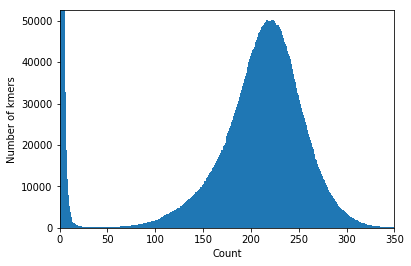

In [1]:
%pylab inline
import os
import matplotlib.pyplot as plt

def PlotKmerHistogram(histofile):
    """
    Takes in the path to a histogram file from jellyfish and 
    plots the kmer count distribution
    """
    max_xval = 350
    max_yval = 52500
    kmer_counts = {} # Dictionary of count -> number of kmers
    # Read the histofile
    # Use its contents to update kmer_counts
    # You also will need to set max_xval and max_yval to something appropriate
    text_file = open(histofile, "r")
    data = text_file.read().splitlines()
    for i in range(len(data)):
        kmer_counts[int(data[i].split()[0])] = int(data[i].split()[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(kmer_counts.keys(), kmer_counts.values(),width=1)
    ax.set_xlabel("Count")
    ax.set_ylabel("Number of kmers")
    if max_xval is not None: ax.set_xlim(left=0, right=max_xval)
    if max_yval is not None: ax.set_ylim(bottom=0, top=max_yval)

PlotKmerHistogram(os.path.join(os.environ["HOME"],"week2","shortfrag.histo")) # may need to edit the path to your file

## 4. Estimating genome size from the kmer distribution

Now we will use the kmer distribution to estimate the size of our E. coli strain. Look back to the prelab to see how we derived the formula for genome size:

$$ G \approx \frac{\texttt{Total num. kmers observed}}{\texttt{Kmer coverage (M)}} $$

**Question 8 (1pt):** First, let's figure out $M$, the average kmer coverage. Recall this is the point where our kmer histogram peaks (ignoring the big spike of error kmers on the left). Figure out the peak by eyeballing the histogram and report your estimate for $M$ below. 

In [18]:
#Can use the numbers of kmers from the file
#This is currently wrong does not multiply by x axis for number of times seen

# file_name = os.path.join(os.environ["HOME"],"week2","shortfrag.histo")
# text_file = open(file_name, "r")
# data = text_file.read().splitlines()
# num_kmers = 0
# for i in range(len(data)):
#     num_kmers = num_kmers + int(data[i].split()[1])
    
# print("Total number of kmers = ",num_kmers)
# print("Estimated genome length (G) = ",(num_kmers/225))

Estimated kmer coverage (M) by eyeballing the distribution ~= 220

**Question 9 (3 pts):**: Now complete the functions `EstimateValley` `EstimateM` below to get a precise estimate of the first valley and peak location after removing errorenous kmers. The first valley is the point where kmer counts start increasing. The peak location ($M$) is the maximum point after the first valley. Make sure your answers look reasonably close to what you what have guessed from just looking at the plot. We'll accept a range of answers.

In [11]:
def LoadKmerCounts(histofile):
    """
    Returns a list of counts where kmer_counts[i-1] = number of kmers seen i times
    """
    kmer_counts_dict = {}
    with open(histofile, "r") as f:
        for line in f:
            count, numkmer = [int(item) for item in line.strip().split()]            
            kmer_counts_dict[count] = numkmer
    kmer_counts = [0]*max(kmer_counts_dict.keys())
    for key in kmer_counts_dict:
        kmer_counts[key-1] = kmer_counts_dict[key]
    return kmer_counts

def EstimateValley(kmer_counts):
    valley = 0
    #say valley is point where there are 3 increases in a row
    past3 = []
    for i,count in enumerate(kmer_counts):
        past3.append(count)
        #only keep the 4 most current values
        if i>3:
            del past3[0]
            
        if i>3 and (past3[-1]>=past3[-2]) and (past3[-2]>=past3[-3]) and (past3[-3]>=past3[-4]):
            break
        
    valley = i
        
    return valley

def EstimateM(kmer_counts, valley_point):
    est_m = 0
    
    past3 = []
    for i,count in enumerate(kmer_counts[valley_point::]):
        past3.append(count)
        if i>3:
            del past3[0]
            
        if i>3 and (past3[-1]<=past3[-2]) and (past3[-2]<=past3[-3]) and (past3[-3]<=past3[-4]):
            break
            
    est_m = i+valley_point
    return est_m

histofile = os.path.join(os.environ["HOME"],"week2","shortfrag.histo")
kmer_counts = LoadKmerCounts(histofile)
est_valley = EstimateValley(kmer_counts)
est_m = EstimateM(kmer_counts, est_valley)
est_valley, est_m #This is the position in the array, to convert to actual times seen add 1, since indexed off 0

(45, 225)

In [12]:
"""Check EstimateValley"""
histofile = os.path.join(os.environ["HOME"],"week2","shortfrag.histo")
kmer_counts = LoadKmerCounts(histofile)
est_valley = EstimateValley(kmer_counts)
assert(est_valley>10 and est_valley<100)

"""Check EstimateM"""
est_m = EstimateM(kmer_counts, est_valley)
assert(est_m>200 and est_m<250)

Now we'll estimate the total number of kmers seen. We will want to ignore kmers that are likely due to errors. Look at your histogram and estimate where the first "valley" is. After this point we can assume kmers seen more than that many times are not due to errors. We can estimate the total number of non-error kmers observed to the right of the first valley point. Keep in mind that for an example data point (count, num kmers), each of those kmers was seen **count** number of times. So you'll want to keep track of 50 * the number of kmers seen 50 times, plus 51 * the number of kmers seen 51 times, etc.

**Question 9 (2 pts):** Complete the function `EstimateNumKmersSeen` below to output an estimate of the number of observed kmers.

In [14]:
def EstimateNumKmersSeen(kmer_counts, valley_point):
    num_total_kmers = 0
    for i, counts in enumerate(kmer_counts[valley_point::]):
        num_total_kmers = num_total_kmers + (i+valley_point+1) * counts #add 1 to valley point since it is indexed off 0
    
    return num_total_kmers

histofile = os.path.join(os.environ["HOME"],"week2","shortfrag.histo")
kmer_counts = LoadKmerCounts(histofile)
est_valley = EstimateValley(kmer_counts)
num_total_kmers = EstimateNumKmersSeen(kmer_counts, est_valley)
num_total_kmers

990527549

In [15]:
"""Checck EstimateNumKmersSeen"""
histofile = os.path.join(os.environ["HOME"],"week2","shortfrag.histo")
kmer_counts = LoadKmerCounts(histofile)
est_valley = EstimateValley(kmer_counts)
num_total_kmers = EstimateNumKmersSeen(kmer_counts, est_valley)
assert(num_total_kmers > 900000000 and num_total_kmers < 1000000000)

**Question 10: (1 pt)** Finally, use your estimates for the total number of kmers seen and for $M$ to estimate the E. coli genome size.

In [17]:
G = num_total_kmers/est_m
print("Estimated genome size", G)

Estimated genome size 4402344.662222222


## 5. Estimating genome size using kmergenie

Now, we'll check our answer by comparing to a tool, **kmergenie**, written to estimate genome sizes from an input set of reads. The tool takes as input a fastq file and outputs several files. We're most interested in `histograms_report.html` that gives a report of the results. Type `kmergenie` to see the usage for this tool.

For the best results, we can give it all of our fastq files. `kmergenie` can take in a file with a list of fastq file paths. To make such a file and run `kmergenie` you can do:

```shell
ls *.fastq.gz* *.fq* > readfiles
```
This lists all the files matching these patterns then writes them (remember the `>` symbol) to the file `readfiles`.

**Question 11 (3 pts):** Run `kmergenie` on our fastq files. Paste the command you used for this below. Look at the html output it produced (`histograms_report.html`). What did it find to be the best value for $k$? What did it predict the genome (assembly) size to be? Is it close to your answer to question 10 above?

Command run: kmergenie readfiles

The best kmer length is listed as 81. The predicted genome size is 4620275. This value is slightly larger than our predicted size.

## 6. Additional exercises

**Question 12 (3 pts)**: Look up the reference assembly info for this E. coli strain https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.3. What is the reported genome size? How does that compare to our estimates? If they are different, hypothesize why.

The reference assembly has 4641652 base pairs. This is a larger value than what we calculated. This could be cause by how we threw out all the kmer reads before our valley point. There could actually be some real values in that portion of the distribution. Furthermore, the errors in the sequencing could cause actual reads to fall into the erroneous reads which would then be left out.

**Question 13 (4 pts)** So far we have considered kmer histograms for a *haploid* organism (E. coli) which only has one copy of the genome. However many organisms (e.g. humans!) we will deal with are *diploid*, meaning they have two copies of the genome, which could have genetic variation from each other. For instance, if you have a heterozygous SNP, then kmers overlapping each of the two alleles will be different.

How do you expect the kmer distribution to change for a diploid genome? Describe the expected pattern of number/location of peaks and valleys you expect and what those correspond to.

You would expect the kmer distribution to have two modes in the distribution if the organism is heterozygous diploid. Most likely there will be some discrepancies between the two copies and hence there will be more than one peak.

**Question 14 (3 pts)**: What will the kmer count distribution look like for a genome sequenced to very low coverage? e.g. $<$5x? Why might this make estimating genome size difficult or impossible?

For a kmer distribution with low coverage the bell curve shape will not be as apparant since it will be hard to differentiate from noise. Thus it will be hard to find the mean coverage (M) and our estimates for the genome sequence length will be very off.